Here we showing how to use the Marginalized Analytic Dataspace Gaussian Inference for Component Separation (MADGICS) method to separate out an emission line from the rest of a spectrum.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

For MADGICS, we need 3 things for separation into two components (n+1 for n components):
- The data we want to separate into components
- A prior covariance matrix for the first component
- A prior covariance matrix for the second component (which can be "everything else")

A practical way to get these prior covariances is to create them from example data of the two components. If you don't have example data, that's okay, you can make them from simulated data, or just estimate the covariance matrix if you have an idea of what it might look like. We can make a covariance matrix out of example data using:

$$
C =  D D^T/n
$$
where D is the data matrix and n is the number of data points (or columns in the data matrix).

# Create simulated data

For demonstration, I'm going to create some simulated spectra that have a couple of emission/absorption lines. Let's pretend that there's one emission line that I'm particularly interested in (for example, like the Ly$\alpha$ line &#x1F440; )

In [3]:
n_spec = 1000
n_wavelengths = 300

In [4]:
def gaussian(x, mu, sigma):
    coeff = 1 / np.sqrt(2 * np.pi * sigma**2)
    return coeff * np.exp(-(x - mu)**2/(2 * sigma**2))

In [5]:
def add_spectral_line(spectra, wavelength_index, width, ampl = 0.1, emission = True):
    num_wavelengths, num_spec = spectra.shape
    sign = 1 if emission else -1
    line_fluxes = sign * np.random.uniform(2,5, num_spec)
    
    emission_line = gaussian(np.arange(n_wavelengths), wavelength_index, np.sqrt(width))

    return spectra + line_fluxes * np.repeat(np.expand_dims(emission_line,0), num_spec, axis=0).T

In [62]:
random_spectra = np.random.rand(n_wavelengths, n_spec)
spectra = add_spectral_line(random_spectra, 100, 5)
spectra = add_spectral_line(spectra, 210, 1)
spectra = add_spectral_line(spectra, 65, 0.5, emission=False)
spectra.shape

(300, 1000)

Now, I'm making three sets of simulated spectra: the spectra to be separated (`total_spectra`), examples of the line I want to pick out at wavelength index 180 (`line_spectra`), and examples of the rest of the spectrum (`noise_spectra`). All of these have the shape (# wavelengths, # spectra).

In [51]:
total_spectra = add_spectral_line(spectra[:, :n_spec//2], 180, 1)
noise_spectra = spectra[:, n_spec//2:]
line_spectra = add_spectral_line(random_spectra*0.5, 180, 1)

# Visualize simulated data

In [60]:
def plot_spectra(spectra, shape = (3,3), ylims=(-2,2), figsize = (9,9)):
    num_spec = spectra.shape[0]
    
    fig, ax = plt.subplots(*shape, figsize=figsize)
    if shape[1] == 1:
        ax = np.expand_dims(ax, axis=1)
    if shape[0] == 1:
        ax = np.expand_dims(ax, axis=0)
    for i in range(shape[0]):
        for j in range(shape[1]):
            ax[i][j].plot(spectra[:,np.random.choice(num_spec)])
            ax[i][j].set_ylim(*ylims)

Here we can just have a look at what these simulated spectra look like. I'm just picking three random examples and plotting them.

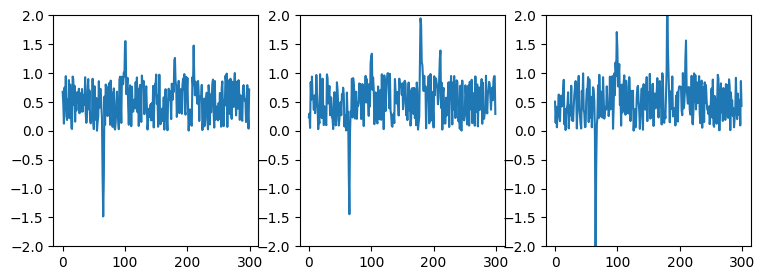

In [61]:
plot_spectra(total_spectra, shape=(1,3), figsize=(9,3))

# Calculate covariance matrices & separate components

Here we can use the MADGICS formulae:
$$
    X_i = C_i C_{tot}^{-1} X_{tot} \quad\text{where} \quad C_{tot} = \sum_{i = 0}^k C_i
$$
to separate out data into constituent components i. Note that these formulae assume the data are centered at zero, so I'm going to subtract the median from each dataset beforehand.

First we make the prior covariance matrices out of our simulated datasets of the line and the rest of the spectrum:

In [11]:
median_subtracted_line_spectra = line_spectra - np.median(line_spectra, axis= 0)
C_line = np.matmul(median_subtracted_line_spectra, median_subtracted_line_spectra.T) / line_spectra.shape[0]

median_subtracted_noise_spectra = noise_spectra - np.median(noise_spectra, axis= 0)
C_noise = np.matmul(median_subtracted_noise_spectra, median_subtracted_noise_spectra.T) / noise_spectra.shape[0]

Ctotinv = np.linalg.inv(C_line + C_noise)

And now we calculate the components:

In [12]:
median_subtracted_total_spectra = total_spectra - np.median(total_spectra, axis= 0)

extracted_lines = np.matmul(np.matmul(C_line, Ctotinv), median_subtracted_total_spectra)
extracted_noise = np.matmul(np.matmul(C_noise, Ctotinv), median_subtracted_total_spectra)

# Visualize components

Here, I'm plotting three random simulated spectra, as well as each of their components.

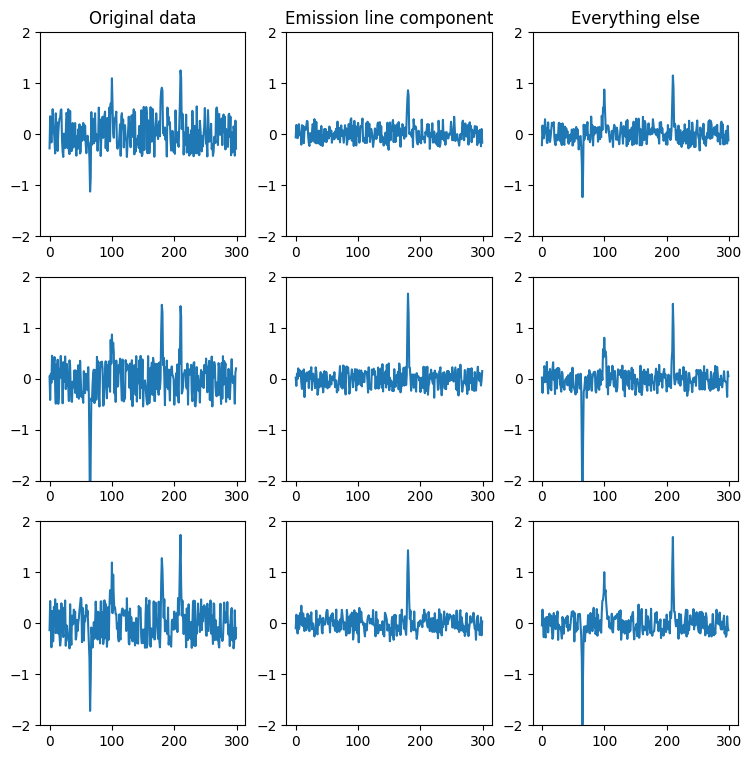

In [58]:
fig, ax = plt.subplots(3,3, figsize=(9,9))

for i in range(3):
    random_index = np.random.choice(np.arange(n_spec//2))
    ax[i][0].plot(median_subtracted_total_spectra[:,random_index])
    ax[i][1].plot(extracted_lines[:,random_index])
    ax[i][2].plot(extracted_noise[:,random_index])

ax[0][0].set_title("Original data")
ax[0][1].set_title("Emission line component")
ax[0][2].set_title("Everything else")

plt.setp(ax, ylim=(-2,2))
plt.show()

You can see that we are able to separate out a specific emission line well using this method.